In [368]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

### CLEAN TEXT + EXPERIENCE

In [369]:
API_KEY = "e5ed8dde-4ada-4aae-b4c8-13fa22eac57c"
API_URL = f"https://jooble.org/api/{API_KEY}"

def clean_html(text):
    """Remove HTML and return plain readable text."""
    soup = BeautifulSoup(text, "lxml")
    return soup.get_text(" ").strip()


def extract_experience(description):
    """Pull phrases like: 2 years, 5-7 years, minimum 3 years etc."""
    if not description:
        return "Not mentioned"

    text = description.lower()
    patterns = [ r'\d+\s*-\s*\d+\s*years?',  # Finds ranges written with a dash Example: "2 - 4 years", "3-5 years", "1-3 year"

                 r'\d+\+?\s*years?',  # Finds numbers followed by "years" (with or without + sign) Example: "3 years", "5+ years", "10+ years"

                r'minimum\s*\d+\s*years?',  # Looks for the word "minimum" before the number Example: "minimum 3 years", "minimum 5 years"

                r'at least\s*\d+\s*years?', # Detects the phrase "at least" before number + years Example: "at least 4 years", "at least 1 year"

                r'\d+\s*yrs' # Catches short form "yrs" Example: "5 yrs", "2yrs", "10 yrs"
            ]

    matches = []
    for pattern in patterns:
        matches.extend(re.findall(pattern, text))

    return ", ".join(sorted(set(matches))) if matches else "Not mentioned"


### FETCH JOBS (WITH PAGINATION)

In [370]:
def fetch_jobs(role, location="India", pages=5, per_page=25):
    """Fetch multiple pages of jobs for a role."""
    rows = []

    for page in range(1, pages + 1):
        payload = {"keywords": role, "location": location, "page": page}
        response = requests.post(API_URL, json=payload, timeout=25).json()

        jobs = response.get("jobs", [])
        if not jobs:   # stop when there are no more pages
            break

        for job in jobs[:per_page]:
            description = clean_html(job.get("description") or job.get("snippet") or "")

            rows.append({
                "search_role": role,
                "title": job.get("title", "N/A"),
                "company": job.get("company", "N/A"),
                "location": job.get("location", "India"),
                "state": job.get("location", "India").split(",")[-2].strip()
                         if "," in job.get("location", "India") else "N/A",
                "salary": job.get("salary") or "Not disclosed",
                "experience_required": extract_experience(description),
                "description": description,
                "updated": job.get("updated", ""),
                "link": job.get("link", "")
            })

    return rows




### COLLECT JOBS FOR MULTIPLE ROLES

In [339]:
roles = ["data analyst", "data scientist", "data engineer", "business analyst"]

all_rows = []
for role in roles:
    all_rows.extend(fetch_jobs(role, pages=10, per_page=25))
df = pd.DataFrame(all_rows).drop_duplicates(
    subset=["title","company","location","link"]
)

df.head()


,search_role,title,company,location,state,salary,experience_required,description,updated,link
0,data analyst,Data Quality Analyst,WeyBee Solutions Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"# Design, implement, and execute data validation and data cleansing processes. \n# Monitor and evaluate data sets for accuracy, completeness... ...identify anomalies. \n# Work closely with data engineers, BI analysts, and business teams to define and enforce data quality rules...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/-7897151293341446366
1,data analyst,Senior Data Analyst,WeyBee Solutions Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"# Collect, clean, and validate data from multiple sources to ensure accuracy and reliability. \n# Analyze complex datasets to identify... ...data pipelines. \n# Provide guidance and mentorship to junior analysts within the team. \n# Document processes, methodologies, and findings...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/1235216392300463110
2,data analyst,Digital Marketing Analyst,APPNWEB Technologies,India,N/A,Not disclosed,Not mentioned,"...email marketing , and social media advertising . \n# Collaborate with the marketing and content teams to optimize strategies. \n# Identify trends, insights, and opportunities for growth. \n# Use A/B testing and data visualization tools to improve results....",2025-11-01T16:50:27.5630000,https://jooble.org/jdp/-8116157699182570036
3,data analyst,Data Engineer,Arna Softech,India,N/A,Not disclosed,Not mentioned,"# Design, develop, and maintain ETL pipelines and data workflows . \n# Work with structured and unstructured data from multiple sources. \n# Collaborate with data scientists, analysts, and business teams to provide clean and reliable data . \n# Optimize data storage...",2025-11-01T00:00:00.0000000,https://jooble.org/jdp/-359541723093599836
4,data analyst,Data Engineer,AheadRace Software Development Services Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"...Design, develop, and maintain scalable ETL/ELT pipelines \n# Build data integration workflows from various data sources (APIs, files,... ..., security, and compliance standards \n# Collaborate with data analysts, BI teams, and software developers \n# Monitor and troubleshoot...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/-4798522485596895228


In [340]:
print("null values:", df.isna().sum().sum())
print("duplicated entry:", df.duplicated().sum())
df["title"].value_counts().head()


null values: 0
duplicated entry: 0


,count
title,
Business Development Executive,24
HR Executive,15
Python Developer,13
MERN Stack Developer,12
Business Analyst,10


### AUTO-DISCOVER TECH SKILLS (TF-IDF + Tech Filter)

“Initial scraped data contained many unrelated roles (HR, sales, software dev).
Using TF-IDF + rule-based filtering, I isolated true data-related roles such as Data Analyst, Business Analyst, and Data Engineer, resulting in a focused dataset for analysis.”

In [341]:
def simple_clean(text):
    """Normalize text for NLP (lowercase + remove symbols)."""
    return re.sub(r'[^a-z0-9 +\-]', ' ', (text or "").lower())


corpus = df["description"].fillna("").apply(simple_clean)

# Learn frequent single + two-word phrases
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,                 # must appear in >= 3 job ads
    stop_words="english"
)

vectorizer.fit(corpus)
terms = vectorizer.get_feature_names_out()

# Keep phrases that LOOK technical (not random business words)
TECH = re.compile(
    r"(sql|python|ml|ai|cloud|etl|data|warehouse|pipeline|server|db|api|"
    r"tableau|power|bi|spark|kafka|snowflake|gcp|aws|azure|docker|git|linux|sas|r )")

auto_skills = sorted([term for term in terms if TECH.search(term)])


In [342]:

def detect_skills_auto(description):
    """Check which discovered skills appear inside description text."""
    text = simple_clean(description)
    found = [skill for skill in auto_skills if skill in text]
    return ", ".join(found) if found else "Not mentioned"


df["skills_auto"] = df["description"].apply(detect_skills_auto)

df.shape

print("title:", df["title"].unique())

print("search_role:", df["search_role"].unique())

df.head()

title: ['Data Quality Analyst' 'Senior Data Analyst' 'Digital Marketing Analyst'
 'Data Engineer' 'Business Analyst' 'Research Analyst' 'Quality Analyst'
 'Sr. Quality Analyst - Automation' 'Senior Data Engineer (Integrations)'
 'Data Engineer - REMOTE' 'Engineer - Data Warehouse Operations'
 'Senior Quality Analyst Lead' 'Quality Control Analyst II'
 'Data Analytics Engineer (Power BI) - REMOTE'
 'Senior Data Analytics Engineer' 'Data Analytics Engineer'
 'Applications Systems Analyst I' 'Data Entry Operator' 'Technical Staff'
 'Technical Assistant' 'Data Engineer (D365 + Azure + Power BI)'
 'Python Developer' 'Python FastAPI Developer'
 'Senior Python Developer (AI/ML)' 'Python + FastAPI Developer'
 'Sr. Python Developer' 'Sr. Business Analyst + Scrum Master'
 'Senior Python Developer' 'Senior Data Scientist (Remote from India)'
 'Java Developer' 'Python / Django Developer' 'Java developer'
 'Python/Django Developer' 'Python (Django) Developer'
 'Python Fullstack Developer' 'Upwork S

,search_role,title,company,location,state,salary,experience_required,description,updated,link,skills_auto
0,data analyst,Data Quality Analyst,WeyBee Solutions Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"# Design, implement, and execute data validation and data cleansing processes. \n# Monitor and evaluate data sets for accuracy, completeness... ...identify anomalies. \n# Work closely with data engineers, BI analysts, and business teams to define and enforce data quality rules...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/-7897151293341446366,"bi, data, data engineer"
1,data analyst,Senior Data Analyst,WeyBee Solutions Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"# Collect, clean, and validate data from multiple sources to ensure accuracy and reliability. \n# Analyze complex datasets to identify... ...data pipelines. \n# Provide guidance and mentorship to junior analysts within the team. \n# Document processes, methodologies, and findings...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/1235216392300463110,"ability, bi, data, data pipelines, datasets, pipeline, pipelines, reliability"
2,data analyst,Digital Marketing Analyst,APPNWEB Technologies,India,N/A,Not disclosed,Not mentioned,"...email marketing , and social media advertising . \n# Collaborate with the marketing and content teams to optimize strategies. \n# Identify trends, insights, and opportunities for growth. \n# Use A/B testing and data visualization tools to improve results....",2025-11-01T16:50:27.5630000,https://jooble.org/jdp/-8116157699182570036,"ai, data, email"
3,data analyst,Data Engineer,Arna Softech,India,N/A,Not disclosed,Not mentioned,"# Design, develop, and maintain ETL pipelines and data workflows . \n# Work with structured and unstructured data from multiple sources. \n# Collaborate with data scientists, analysts, and business teams to provide clean and reliable data . \n# Optimize data storage...",2025-11-01T00:00:00.0000000,https://jooble.org/jdp/-359541723093599836,"ai, data, data scientists, data storage, etl, maintain, pipeline, pipelines"
4,data analyst,Data Engineer,AheadRace Software Development Services Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"...Design, develop, and maintain scalable ETL/ELT pipelines \n# Build data integration workflows from various data sources (APIs, files,... ..., security, and compliance standards \n# Collaborate with data analysts, BI teams, and software developers \n# Monitor and troubleshoot...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/-4798522485596895228,"ai, api, apis, bi, data, data sources, etl, maintain, pipeline, pipelines"


### Bucketing of core and non core data job titles

In [343]:
df["is_core_data_role"] = df["title"].str.contains(
    r"(data|ml|analytics|business analyst|bi|machine learning|data engineer)",
    case=False,
    regex=True
)



core_data_jobs=df[df.is_core_data_role == True]
print("unique title in core data jobs:", core_data_jobs["title"].unique())
print("core data job shape:", core_data_jobs.shape)
core_data_jobs.head()

unique title in core data jobs: ['Data Quality Analyst' 'Senior Data Analyst' 'Data Engineer'
 'Business Analyst' 'Senior Data Engineer (Integrations)'
 'Data Engineer - REMOTE' 'Engineer - Data Warehouse Operations'
 'Data Analytics Engineer (Power BI) - REMOTE'
 'Senior Data Analytics Engineer' 'Data Analytics Engineer'
 'Data Entry Operator' 'Data Engineer (D365 + Azure + Power BI)'
 'Senior Python Developer (AI/ML)' 'Sr. Business Analyst + Scrum Master'
 'Senior Data Scientist (Remote from India)'
 'Community Mobilization Specialist' 'Staff Data Scientist'
 'BI QA Engineer' 'Sr. Data Engineer' 'Senior Data Engineer'
 'Senior Engineer - Data Warehouse Operations' 'Senior Data Scientist'
 'AI/ML Engineer' 'AI / ML Engineer' 'AI/ML Developer'
 'Business Analyst (Pre Sales)' 'Senior Business Analyst'
 'Power BI Developer' 'Sr. Business Analyst' 'Machine Learning Engineer'
 'MLOps Engineer' 'Mobile App Developer'
 'Mobile Engineer (Remote from India)'
 'Project Manager / Project Coordin

/tmp/ipython-input-3824675604.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["is_core_data_role"] = df["title"].str.contains(


,search_role,title,company,location,state,salary,experience_required,description,updated,link,skills_auto,is_core_data_role
0,data analyst,Data Quality Analyst,WeyBee Solutions Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"# Design, implement, and execute data validation and data cleansing processes. \n# Monitor and evaluate data sets for accuracy, completeness... ...identify anomalies. \n# Work closely with data engineers, BI analysts, and business teams to define and enforce data quality rules...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/-7897151293341446366,"bi, data, data engineer",True
1,data analyst,Senior Data Analyst,WeyBee Solutions Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"# Collect, clean, and validate data from multiple sources to ensure accuracy and reliability. \n# Analyze complex datasets to identify... ...data pipelines. \n# Provide guidance and mentorship to junior analysts within the team. \n# Document processes, methodologies, and findings...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/1235216392300463110,"ability, bi, data, data pipelines, datasets, pipeline, pipelines, reliability",True
3,data analyst,Data Engineer,Arna Softech,India,N/A,Not disclosed,Not mentioned,"# Design, develop, and maintain ETL pipelines and data workflows . \n# Work with structured and unstructured data from multiple sources. \n# Collaborate with data scientists, analysts, and business teams to provide clean and reliable data . \n# Optimize data storage...",2025-11-01T00:00:00.0000000,https://jooble.org/jdp/-359541723093599836,"ai, data, data scientists, data storage, etl, maintain, pipeline, pipelines",True
4,data analyst,Data Engineer,AheadRace Software Development Services Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"...Design, develop, and maintain scalable ETL/ELT pipelines \n# Build data integration workflows from various data sources (APIs, files,... ..., security, and compliance standards \n# Collaborate with data analysts, BI teams, and software developers \n# Monitor and troubleshoot...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/-4798522485596895228,"ai, api, apis, bi, data, data sources, etl, maintain, pipeline, pipelines",True
5,data analyst,Business Analyst,Innvonix Tech Solutions Private Limited,India,N/A,Not disclosed,Not mentioned,"...business stakeholders to ensure smooth project execution. \n# Assist in defining project scope, objectives, and deliverables. \n# Perform data analysis using SQL, Excel, or BI tools to support decision-making. \n# Conduct User Acceptance Testing (UAT) and validate...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/3084267760082808364,"bi, bi tools, data, sql, using sql",True


In [344]:
non_core_data_jobs=df[df.is_core_data_role == False]
print("non core data job:", non_core_data_jobs["title"].unique())
print("non core data job shape:", non_core_data_jobs.shape)
non_core_data_jobs.head()

non core data job: ['Digital Marketing Analyst' 'Research Analyst' 'Quality Analyst'
 'Sr. Quality Analyst - Automation' 'Senior Quality Analyst Lead'
 'Quality Control Analyst II' 'Applications Systems Analyst I'
 'Technical Staff' 'Technical Assistant' 'Python Developer'
 'Python FastAPI Developer' 'Python + FastAPI Developer'
 'Sr. Python Developer' 'Senior Python Developer' 'Java Developer'
 'Python / Django Developer' 'Java developer' 'Python/Django Developer'
 'Python (Django) Developer' 'Python Fullstack Developer'
 'Upwork Specialist BDE' 'Youth Prevention Specialist'
 'E-Listing Specialist' 'Ads Specialist' 'Java Full stack developer'
 'Java Fullstack Developer' 'QC Chemist' 'Estimation engineer'
 'Senior Engineer' 'Graduate engineer trainee' 'QC Engineer'
 'Sr. Engineer' 'Civil Engineers' 'Sr. QC Engineer' 'SQA Engineer'
 'Senior Engineer - Quality' 'Estimation Engineer' 'Purchase Engineer'
 'Jr. Engineer - R&D' 'EC Engineer' 'Trainee Engineer - QA'
 'Jr. Engineer - Productio

,search_role,title,company,location,state,salary,experience_required,description,updated,link,skills_auto,is_core_data_role
2,data analyst,Digital Marketing Analyst,APPNWEB Technologies,India,N/A,Not disclosed,Not mentioned,"...email marketing , and social media advertising . \n# Collaborate with the marketing and content teams to optimize strategies. \n# Identify trends, insights, and opportunities for growth. \n# Use A/B testing and data visualization tools to improve results....",2025-11-01T16:50:27.5630000,https://jooble.org/jdp/-8116157699182570036,"ai, data, email",False
15,data analyst,Research Analyst,Mindcog,India,N/A,Not disclosed,Not mentioned,"...research on education trends, competitors, and market opportunities. \n# Collect, organize, and analyze quantitative and qualitative data. \n# Prepare reports, presentations, and dashboards to summarize findings. \n# Support decision-making by providing actionable...",2025-11-01T00:00:00.0000000,https://jooble.org/jdp/-4614575503069517563,data,False
16,data analyst,Quality Analyst,AirVincible,India,N/A,Not disclosed,Not mentioned,"#Conduct manual or automated testing of products, software, or processes. \n# Identify, document, and track bugs or quality issues. \n# Collaborate with developers, designers, and production teams to resolve issues. \n# Develop and execute test plans, test cases, and test...",2025-11-03T17:35:24.7000000,https://jooble.org/jdp/1538122770222398748,Not mentioned,False
17,data analyst,Quality Analyst,Esferasoft Solutions Pvt. Ltd.,India,N/A,Not disclosed,Not mentioned,"# Analyze business and technical requirements to design effective test plans and test cases . \n# Perform manual and/or automated testing of software applications. \n# Identify, record, and track software defects using tools like JIRA, Bugzilla, or Trello . \n# Conduct...",2025-10-28T15:52:55.8470000,https://jooble.org/jdp/-4473524198979849600,Not mentioned,False
18,data analyst,Quality Analyst,WeyBee Solutions Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"# Analyze software requirements and functional specifications to create detailed test plans and test cases . \n# Execute manual and automated testing to validate software functionality and performance. \n# Identify, document, and track defects using tools like JIRA...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/3952394690241369976,"ai, create detailed, detailed",False


### clean up for experience of column

In [345]:
import re

def clean_experience(text):
    if not text or text.lower() == "not mentioned":
        return "Not mentioned"

    # normalize text
    t = text.lower().replace("\n", " ").replace("yrs", "years").replace("yr", "year")

    # extract all numbers
    nums = re.findall(r"\d+", t)

    if not nums:
        return "Not mentioned"

    years = sorted(map(int, nums))

    # pattern handling
    if "minimum" in t or "+" in t:
        return f"{years[0]}+ years"

    if len(years) > 1:
        return f"{years[0]}–{years[-1]} years"

    return f"{years[0]} years"

df["experience_required"] = df["experience_required"].apply(clean_experience)
df.head()

,search_role,title,company,location,state,salary,experience_required,description,updated,link,skills_auto,is_core_data_role
0,data analyst,Data Quality Analyst,WeyBee Solutions Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"# Design, implement, and execute data validation and data cleansing processes. \n# Monitor and evaluate data sets for accuracy, completeness... ...identify anomalies. \n# Work closely with data engineers, BI analysts, and business teams to define and enforce data quality rules...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/-7897151293341446366,"bi, data, data engineer",True
1,data analyst,Senior Data Analyst,WeyBee Solutions Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"# Collect, clean, and validate data from multiple sources to ensure accuracy and reliability. \n# Analyze complex datasets to identify... ...data pipelines. \n# Provide guidance and mentorship to junior analysts within the team. \n# Document processes, methodologies, and findings...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/1235216392300463110,"ability, bi, data, data pipelines, datasets, pipeline, pipelines, reliability",True
2,data analyst,Digital Marketing Analyst,APPNWEB Technologies,India,N/A,Not disclosed,Not mentioned,"...email marketing , and social media advertising . \n# Collaborate with the marketing and content teams to optimize strategies. \n# Identify trends, insights, and opportunities for growth. \n# Use A/B testing and data visualization tools to improve results....",2025-11-01T16:50:27.5630000,https://jooble.org/jdp/-8116157699182570036,"ai, data, email",False
3,data analyst,Data Engineer,Arna Softech,India,N/A,Not disclosed,Not mentioned,"# Design, develop, and maintain ETL pipelines and data workflows . \n# Work with structured and unstructured data from multiple sources. \n# Collaborate with data scientists, analysts, and business teams to provide clean and reliable data . \n# Optimize data storage...",2025-11-01T00:00:00.0000000,https://jooble.org/jdp/-359541723093599836,"ai, data, data scientists, data storage, etl, maintain, pipeline, pipelines",True
4,data analyst,Data Engineer,AheadRace Software Development Services Pvt Ltd,India,N/A,Not disclosed,Not mentioned,"...Design, develop, and maintain scalable ETL/ELT pipelines \n# Build data integration workflows from various data sources (APIs, files,... ..., security, and compliance standards \n# Collaborate with data analysts, BI teams, and software developers \n# Monitor and troubleshoot...",2025-10-28T00:00:00.0000000,https://jooble.org/jdp/-4798522485596895228,"ai, api, apis, bi, data, data sources, etl, maintain, pipeline, pipelines",True


In [346]:
df.to_csv("jooble_data.csv", index=False)

In [347]:
import sqlite3

# create (or connect to) database file
conn = sqlite3.connect("jobs.db")

# store dataframe in sqlite table
df.to_sql("jobs", conn, if_exists="replace", index=False)

conn.commit()
print("Saved to SQLite successfully!")


Saved to SQLite successfully!


In [348]:
df = pd.read_sql("""
SELECT
    is_core_data_role,
    COUNT(*) AS job_count
FROM jobs
GROUP BY is_core_data_role;
""", conn)

df["percent"] = (df["job_count"] / df["job_count"].sum()) * 100
df


,is_core_data_role,job_count,percent
0,0,422,88.842105
1,1,53,11.157895


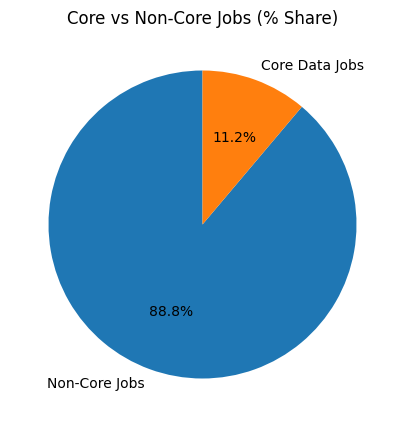

In [349]:
df["role_type"] = df["is_core_data_role"].map({
    1: "Core Data Jobs",
    0: "Non-Core Jobs"
})


plt.figure(figsize=(5,5))

plt.pie(
    df["percent"],
    labels=df["role_type"],
    autopct="%.1f%%",
    startangle=90
)

plt.title("Core vs Non-Core Jobs (% Share)")
plt.show()


"Only about 11% of postings in the dataset are true core data roles (DA, DS, DE, ML), while ~89% are adjacent or non-core roles such as QA, marketing, ops, or general IT roles."

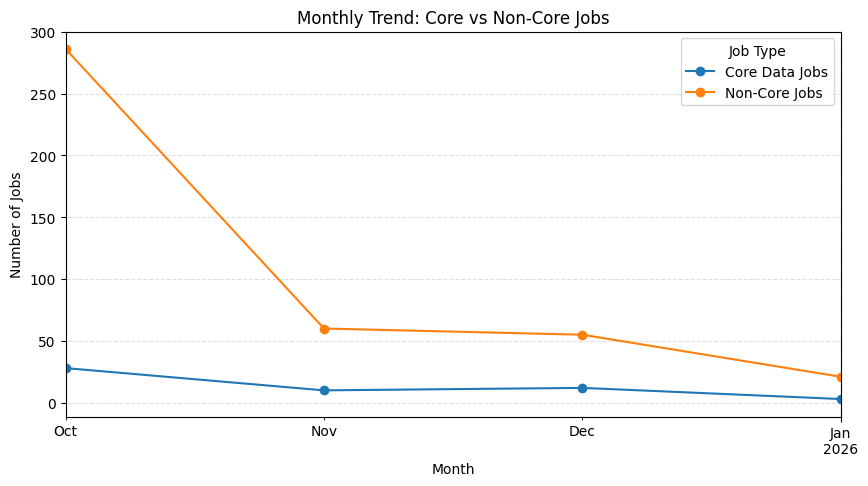

In [350]:
df_trend = pd.read_sql("""
SELECT
    is_core_data_role,
    substr(updated,1,7) AS month,
    COUNT(*) AS jobs
FROM jobs
GROUP BY is_core_data_role, month
ORDER BY month;
""", conn)

df_trend["role_type"] = df_trend["is_core_data_role"].map({
    1: "Core Data Jobs",
    0: "Non-Core Jobs"
})

df_trend["month"] = pd.to_datetime(df_trend["month"])
pivot = df_trend.pivot(index="month", columns="role_type", values="jobs")

pivot.plot(kind="line", marker="o", figsize=(10,5))

plt.title("Monthly Trend: Core vs Non-Core Jobs")
plt.xlabel("Month")
plt.ylabel("Number of Jobs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Job Type")
plt.show()



        search_role  total_jobs
0      data analyst          31
1    data scientist          17
2     data engineer           4
3  business analyst           1


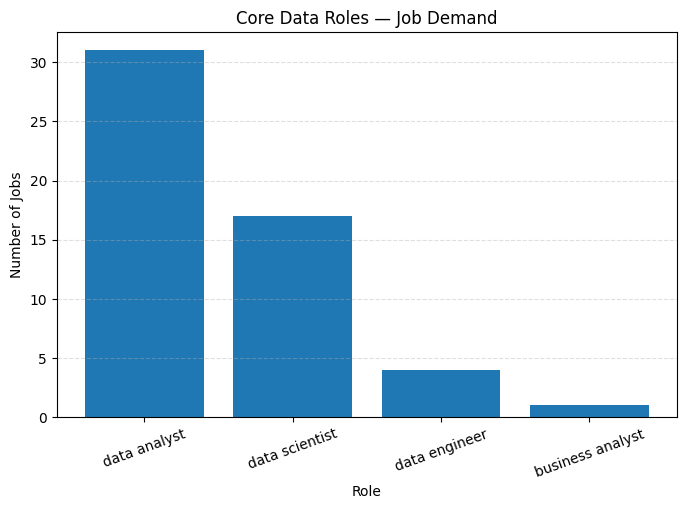

In [351]:
df = pd.read_sql("""
SELECT
    search_role,
    COUNT(*) AS total_jobs
FROM jobs
WHERE is_core_data_role = 1
GROUP BY search_role
ORDER BY total_jobs DESC;
""", conn)

print(df)
plt.figure(figsize=(8,5))

plt.bar(df["search_role"], df["total_jobs"])

plt.title("Core Data Roles — Job Demand")
plt.xlabel("Role")
plt.ylabel("Number of Jobs")
plt.grid(axis="y", linestyle="--", alpha=0.4)


plt.xticks(rotation=20)
plt.show()


Data Analyst sits at the top among core data roles

###Core data jobs experiene requirment

In [352]:
pd.read_sql("""
SELECT
    experience_required,
    COUNT(*) AS count
FROM jobs
WHERE is_core_data_role = 1
GROUP BY experience_required
ORDER BY count DESC;
""", conn)


,experience_required,count
0,Not mentioned,52
1,3 years,1


### Non core data jobs experiene requirment

In [353]:
pd.read_sql("""
SELECT
    experience_required,
    COUNT(*) AS count
FROM jobs
WHERE is_core_data_role = 0
GROUP BY experience_required
ORDER BY count DESC;
""", conn)


,experience_required,count
0,Not mentioned,406
1,5+ years,3
2,4 years,3
3,5 years,2
4,9 years,1
5,8 years,1
6,3+ years,1
7,3 years,1
8,2 years,1
9,10+ years,1


### Top 10 companies hiring for core data roles:

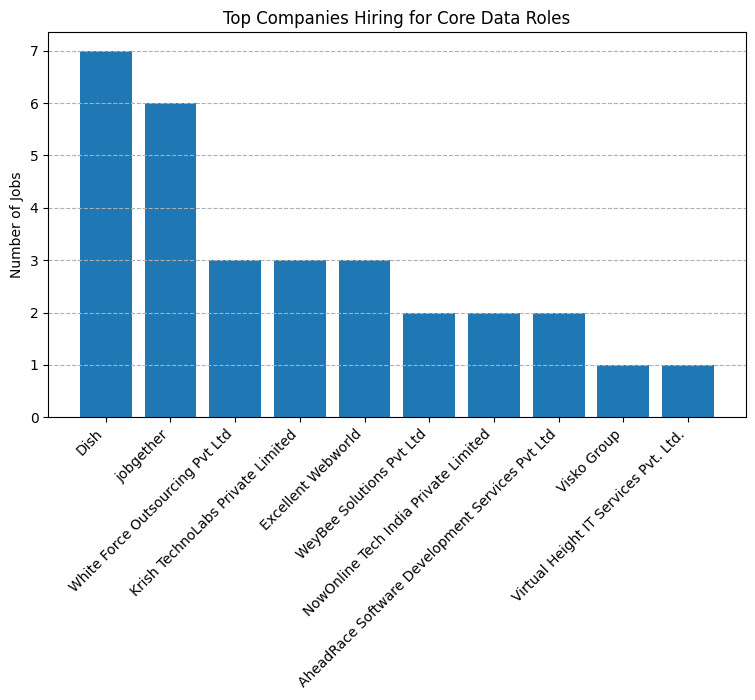

In [354]:
df=pd.read_sql("""
SELECT
    company,
    COUNT(*) AS jobs
FROM jobs
WHERE is_core_data_role = 1
GROUP BY company
ORDER BY jobs DESC
LIMIT 10;
""", conn)


plt.figure(figsize=(9,5))

plt.bar(df["company"], df["jobs"])
plt.xticks(rotation=45, ha="right")

plt.title("Top Companies Hiring for Core Data Roles")
plt.ylabel("Number of Jobs")
plt.grid(axis="y", linestyle="--")

plt.show()


### Monthly trend of core-data jobs

     month  job_count
0  2025-10         28
1  2025-11         10
2  2025-12         12
3  2026-01          3


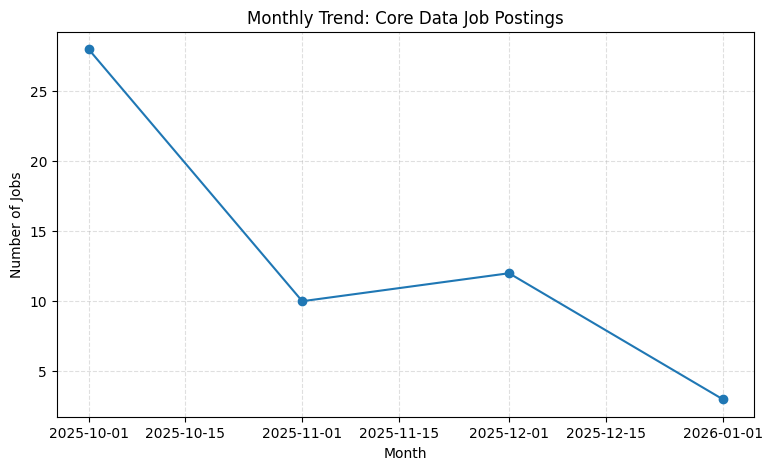

In [355]:
df=pd.read_sql("""
SELECT
    substr(updated, 1, 7) AS month,
    COUNT(*) AS job_count
FROM jobs
WHERE is_core_data_role = 1
GROUP BY month
ORDER BY month;
""", conn)

print(df)


df["month"] = pd.to_datetime(df["month"])

plt.figure(figsize=(9,5))

plt.plot(df["month"], df["job_count"], marker="o")

plt.title("Monthly Trend: Core Data Job Postings")
plt.xlabel("Month")
plt.ylabel("Number of Jobs")
plt.grid(True, linestyle="--", alpha=0.4)

plt.show()

### Top 10 companies hiring for non core data roles

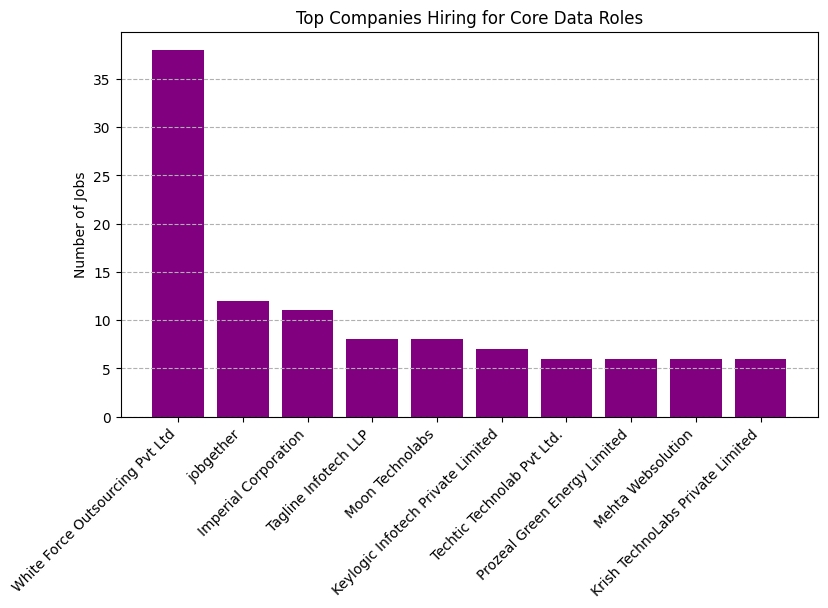

In [356]:
df=pd.read_sql("""
SELECT
    company,
    COUNT(*) AS jobs
FROM jobs
WHERE is_core_data_role = 0
GROUP BY company
ORDER BY jobs DESC
LIMIT 10;
""", conn)


plt.figure(figsize=(9,5))

plt.bar(df["company"], df["jobs"], color="purple")
plt.xticks(rotation=45, ha="right")

plt.title("Top Companies Hiring for Core Data Roles")
plt.ylabel("Number of Jobs")
plt.grid(axis="y", linestyle="--")

plt.show()


### Monthly trend of non core-data jobs

     month  job_count
0  2025-10        286
1  2025-11         60
2  2025-12         55
3  2026-01         21


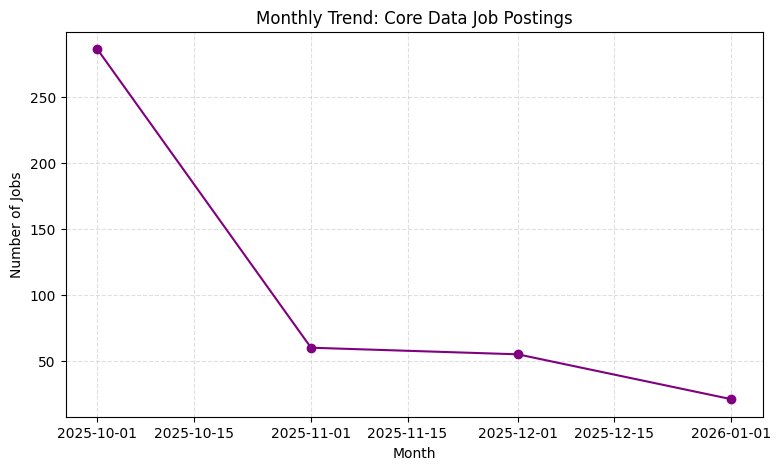

In [357]:
df=pd.read_sql("""
SELECT
    substr(updated, 1, 7) AS month,
    COUNT(*) AS job_count
FROM jobs
WHERE is_core_data_role = 0
GROUP BY month
ORDER BY month;
""", conn)

print(df)

df["month"] = pd.to_datetime(df["month"])

plt.figure(figsize=(9,5))

plt.plot(df["month"], df["job_count"], marker="o", color="purple")

plt.title("Monthly Trend: Core Data Job Postings")
plt.xlabel("Month")
plt.ylabel("Number of Jobs")
plt.grid(True, linestyle="--", alpha=0.4)

### Most Frequent job in non core data jobs

                            title  freq
0  Business Development Executive    24
1                    HR Executive    15
2                Python Developer    13
3            MERN Stack Developer    12
4               Flutter Developer     9


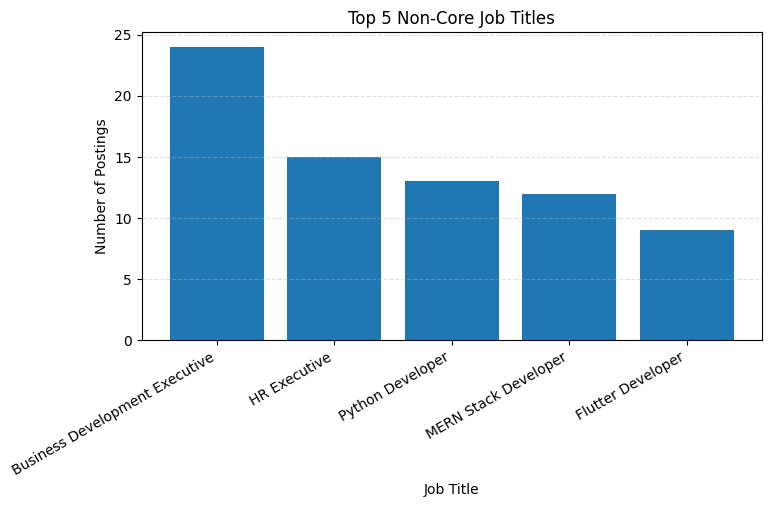

In [358]:
df=pd.read_sql("""
SELECT
    title,
    COUNT(*) AS freq
FROM jobs
WHERE is_core_data_role = 0
GROUP BY title
ORDER BY freq DESC
LIMIT 5;
""", conn)

print(df)

plt.figure(figsize=(8,4))

plt.bar(df["title"], df["freq"])

plt.title("Top 5 Non-Core Job Titles")
plt.xlabel("Job Title")
plt.ylabel("Number of Postings")
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xticks(rotation=30, ha="right")
plt.show()


"The majority of non-core postings come from business development, HR, and software developer roles.
This confirms why bucketing was necessary — without filtering, these unrelated roles would distort analytics insights about the data job market."

In [359]:
df = pd.read_sql("""
SELECT search_role, COUNT(*) AS total
FROM jobs
WHERE search_role IN ('data analyst','business analyst')
GROUP BY search_role;
""", conn)

df["percent"] = (df["total"] / df["total"].sum()) * 100
df


,search_role,total,percent
0,business analyst,76,35.185185
1,data analyst,140,64.814815


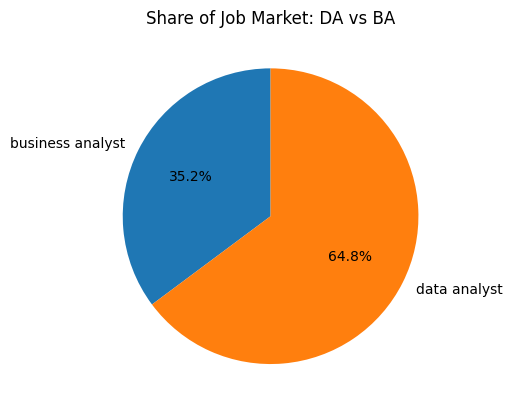

In [360]:
plt.pie(
    df["percent"],
    labels=df["search_role"],
    autopct="%.1f%%",
    startangle=90
)

plt.title("Share of Job Market: DA vs BA")
plt.show()

### Experience requirement for BA and DA

In [361]:
pd.read_sql("""
SELECT search_role, experience_required, COUNT(*) AS jobs
FROM jobs
WHERE search_role IN ('data analyst','business analyst')
GROUP BY search_role, experience_required
ORDER BY search_role, jobs DESC;
""", conn)


,search_role,experience_required,jobs
0,business analyst,Not mentioned,73
1,business analyst,5+ years,1
2,business analyst,4 years,1
3,business analyst,1 years,1
4,data analyst,Not mentioned,134
5,data analyst,3 years,2
6,data analyst,9 years,1
7,data analyst,8 years,1
8,data analyst,2 years,1
9,data analyst,1+ years,1


### Top 5 Data Analyst hiring companies

In [362]:
da_df = pd.read_sql("""
SELECT
    company,
    COUNT(*) AS jobs
FROM jobs
WHERE search_role = 'data analyst'
GROUP BY company
ORDER BY jobs DESC
LIMIT 5;
""", conn)

da_df


,company,jobs
0,White Force Outsourcing Pvt Ltd,15
1,Imperial Corporation,7
2,jobgether,6
3,WeyBee Solutions Pvt Ltd,4
4,Excellent Webworld,4


### Top 5 Business Analyst hiring companies

In [363]:
ba_df = pd.read_sql("""
SELECT
    company,
    COUNT(*) AS jobs
FROM jobs
WHERE search_role = 'business analyst'
GROUP BY company
ORDER BY jobs DESC
LIMIT 5;
""", conn)

ba_df

,company,jobs
0,White Force Outsourcing Pvt Ltd,11
1,Moon Technolabs,4
2,jobgether,3
3,Visko Group,3
4,Technource,2


### Monthly job trend for BA and DA

In [364]:
pd.read_sql("""
SELECT
    search_role,
    substr(updated,1,7) AS month,
    COUNT(*) AS jobs
FROM jobs
WHERE search_role IN ('data analyst','business analyst')
GROUP BY search_role, month
ORDER BY month, search_role;
""", conn)


,search_role,month,jobs
0,business analyst,2025-10,48
1,data analyst,2025-10,87
2,business analyst,2025-11,12
3,data analyst,2025-11,22
4,business analyst,2025-12,12
5,data analyst,2025-12,22
6,business analyst,2026-01,4
7,data analyst,2026-01,9


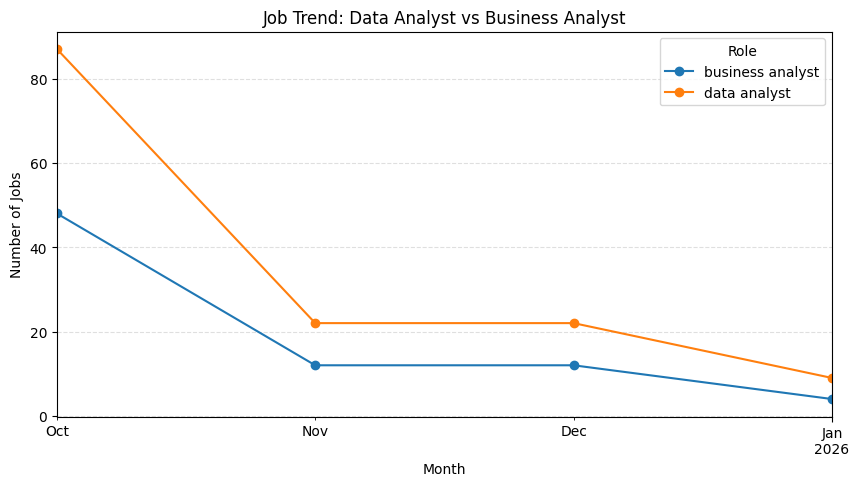

In [365]:
# First, get the data for plotting directly into df
df = pd.read_sql("""
SELECT
    search_role,
    substr(updated,1,7) AS month,
    COUNT(*) AS jobs
FROM jobs
WHERE search_role IN ('data analyst','business analyst')
GROUP BY search_role, month
ORDER BY month, search_role;
""", conn)

# convert month to datetime (for nicer sorting)
df["month"] = pd.to_datetime(df["month"])

# pivot so each role becomes a line
pivot_df = df.pivot(index="month", columns="search_role", values="jobs")

pivot_df.plot(kind="line", marker="o", figsize=(10,5))

plt.title("Job Trend: Data Analyst vs Business Analyst")
plt.xlabel("Month")
plt.ylabel("Number of Jobs")
plt.legend(title="Role")
plt.grid(True, linestyle="--", alpha=0.4)

plt.show()

In [366]:
df_share = (
    df
    .groupby("month")
    .apply(lambda g: g.assign(
        market_share = g["jobs"] / g["jobs"].sum() * 100
    ))
    .reset_index(drop=True)
)

df_share


/tmp/ipython-input-509927485.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(


,search_role,month,jobs,market_share
0,business analyst,2025-10-01,48,35.555556
1,data analyst,2025-10-01,87,64.444444
2,business analyst,2025-11-01,12,35.294118
3,data analyst,2025-11-01,22,64.705882
4,business analyst,2025-12-01,12,35.294118
5,data analyst,2025-12-01,22,64.705882
6,business analyst,2026-01-01,4,30.769231
7,data analyst,2026-01-01,9,69.230769


In [367]:
da = df_share[df_share["search_role"] == "data analyst"].copy()

da["pct_change_market_share"] = da["market_share"].pct_change() * 100

da


,search_role,month,jobs,market_share,pct_change_market_share
1,data analyst,2025-10-01,87,64.444444,NaN
3,data analyst,2025-11-01,22,64.705882,0.405680
5,data analyst,2025-12-01,22,64.705882,0.000000
7,data analyst,2026-01-01,9,69.230769,6.993007


“Across the observed period, Data Analyst roles held ~65–70% of analytics hiring demand, consistently overtaking Business Analyst roles, which remained around 30–35%. Growth spikes suggest businesses are prioritizing hands-on analytical execution over purely business-facing analytics functions.”